In [1]:
!git clone https://github.com/richzhang/PerceptualSimilarity

Cloning into 'PerceptualSimilarity'...


%cd PerceptualSimilarity/

!pip install -r requirements.txt

In [15]:
import cv2
import lpips
import torch
import numpy as np

In [4]:
def numpy_to_lpips_tensor(img_np):
    """Converts OpenCV HWC array (0-255) to LPIPS's NCHW (-1 to 1) tensor."""
    if img_np.dtype == np.uint8:
        img_np = img_np.astype(np.float32)

    # HWC -> CHW (permute) -> NCHW (unsqueeze)
    # LPIPS requires 3 color channels (even for grayscale), so we must ensure 3 dimensions
    if img_np.ndim == 2: # Handle grayscale image
        img_np = cv2.cvtColor(img_np.astype(np.uint8), cv2.COLOR_GRAY2BGR).astype(np.float32)

    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0)
    
    # Normalize from [0, 255] to [-1, 1] (Required by LPIPS)
    img_tensor = img_tensor / 127.5 - 1.0 
    
    return img_tensor

def calculate_lpips(imageA, imageB, loss_fn):
    """Calculates the LPIPS score between two images."""

    if imageA is None or imageB is None:
        print("Error in LPIPS: One or both images failed to load.")
        return float('inf') 

    # Convert NumPy arrays to LPIPS compatible tensors
    tensorA = numpy_to_lpips_tensor(imageA)
    tensorB = numpy_to_lpips_tensor(imageB)
    
    # Calculate LPIPS distance (returns a tensor)
    # LPIPS is a distance metric; a lower score means higher perceptual similarity.
    with torch.no_grad():
        d = loss_fn.forward(tensorA, tensorB)
    
    # Extract the scalar distance
    return d.item()

In [8]:
# --- File Paths (Using the corrected path from previous debugging) ---
ori_path = r'D:\GLAZE-evaluation\dataset\Invariance\ori.png'
glz_path = r'D:\GLAZE-evaluation\dataset\Invariance\glz.png'
# NOTE: Adjusted the assumed image name inside the directory
lora_ori_path = r'D:\GLAZE-evaluation\dataset\Invariance\lora-ori.png'
lora_glz_path = r'D:\GLAZE-evaluation\dataset\Invariance\lora-glz.png'

# --- Load Images ---
print("--- Loading Images ---")
ori_img = cv2.imread(ori_path)
glz_img = cv2.imread(glz_path)
lora_ori_img = cv2.imread(lora_ori_path)
lora_glz_img = cv2.imread(lora_glz_path)

if ori_img is None: print(f"Failed to load: {ori_path}")
if glz_img is None: print(f"Failed to load: {glz_path}")
if lora_ori_img is None: print(f"Failed to load: {lora_ori_path}")
if lora_glz_img is None: print(f"Failed to load: {lora_glz_path}")

--- Loading Images ---


In [16]:
# --- LPIPS Calculations ---
print("\n--- LPIPS Calculations ---")
lpips_model = None
if lpips is not None and torch is not None:
    try:
        # Initialize LPIPS model once for efficiency (using AlexNet as feature extractor)
        lpips_model = lpips.LPIPS(net='alex')
        lpips_model.eval() # Set model to evaluation mode
        
        # ori vs lora_ori
        ori_lpips = calculate_lpips(ori_img, lora_ori_img, lpips_model)
        print(f"LPIPS (ori vs lora_ori) is {ori_lpips:.4f}")

        # ori vs lora_glz
        origlz_lpips = calculate_lpips(ori_img, lora_glz_img, lpips_model)
        print(f"LPIPS (ori vs lora_glz) is {origlz_lpips:.4f}")

        # glz vs lora_glz
        glz_lpips = calculate_lpips(glz_img, lora_glz_img, lpips_model)
        print(f"LPIPS (glz vs lora_glz) is {glz_lpips:.4f}")

    except Exception as e:
        print(f"LPIPS calculation failed during execution: {e}")
        print("Please ensure your image inputs are valid and the environment is properly set up.")
else:
    print("LPIPS calculation skipped due to missing PyTorch or LPIPS library.")


--- LPIPS Calculations ---
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: d:\GLAZE-evaluation\PerceptualSimilarity\lpips\weights\v0.1\alex.pth
LPIPS (ori vs lora_ori) is 0.4520
LPIPS (ori vs lora_glz) is 0.5361
LPIPS (glz vs lora_glz) is 0.5334


In [17]:
import matplotlib.pyplot as plt

def plot_lpips_comparison(img1, img2, name1, name2, lpips):
    """Plots two images side-by-side with only the LPIPS score."""
    if img1 is None or img2 is None:
        print(f"Skipping plot for {name1} vs {name2} due to missing image data.")
        return 

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Convert BGR (OpenCV default) to RGB (Matplotlib default)
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Plot Image 1
    axes[0].imshow(img1_rgb)
    axes[0].set_title(f"A: {name1}", fontsize=14)
    axes[0].axis('off')

    # Plot Image 2
    axes[1].imshow(img2_rgb)
    axes[1].set_title(f"B: {name2}", fontsize=14)
    axes[1].axis('off')
    
    # Create the score summary text
    score_text = f"--- LPIPS Comparison: {name1} vs {name2} ---\n"
    score_text += f"LPIPS Score: {lpips:.2f} dB"
    
    fig.suptitle(score_text, fontsize=16, fontweight='bold', y=0.05)
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()

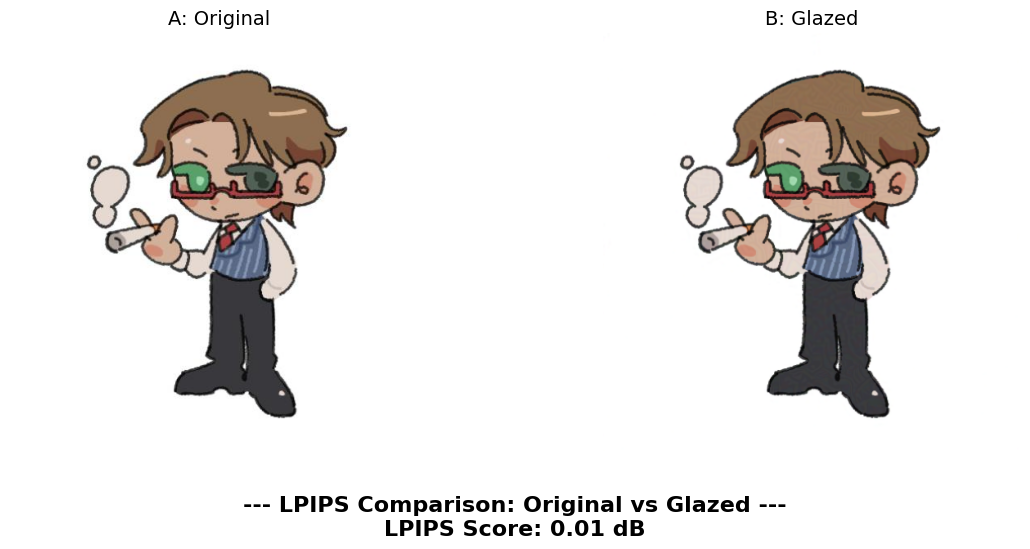

In [19]:
plot_lpips_comparison(ori_img, glz_img, "Original", "Glazed", calculate_lpips(ori_img, glz_img, lpips_model))

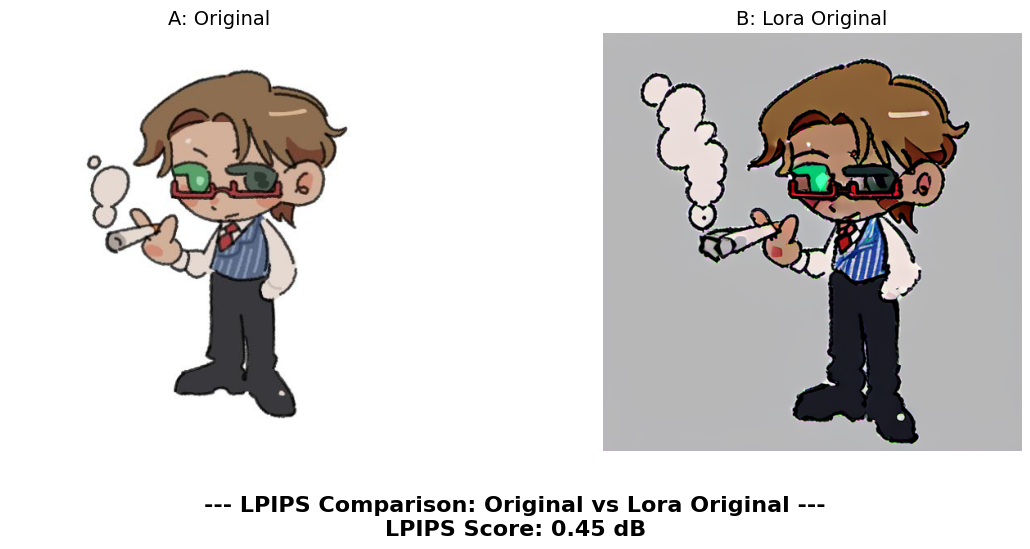

In [21]:
plot_lpips_comparison(ori_img, lora_ori_img, "Original", "Lora Original", ori_lpips)

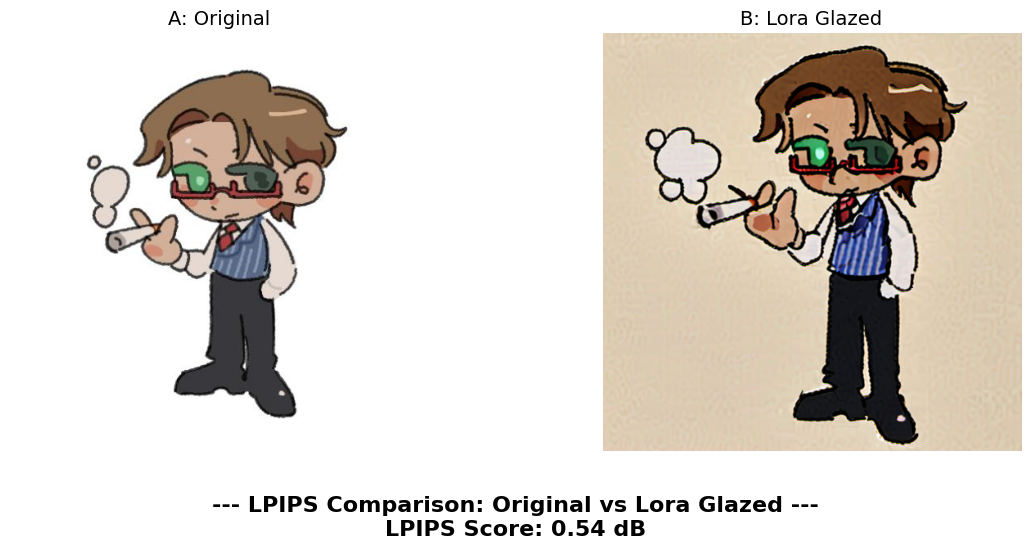

In [22]:
plot_lpips_comparison(ori_img, lora_glz_img, "Original", "Lora Glazed", origlz_lpips)

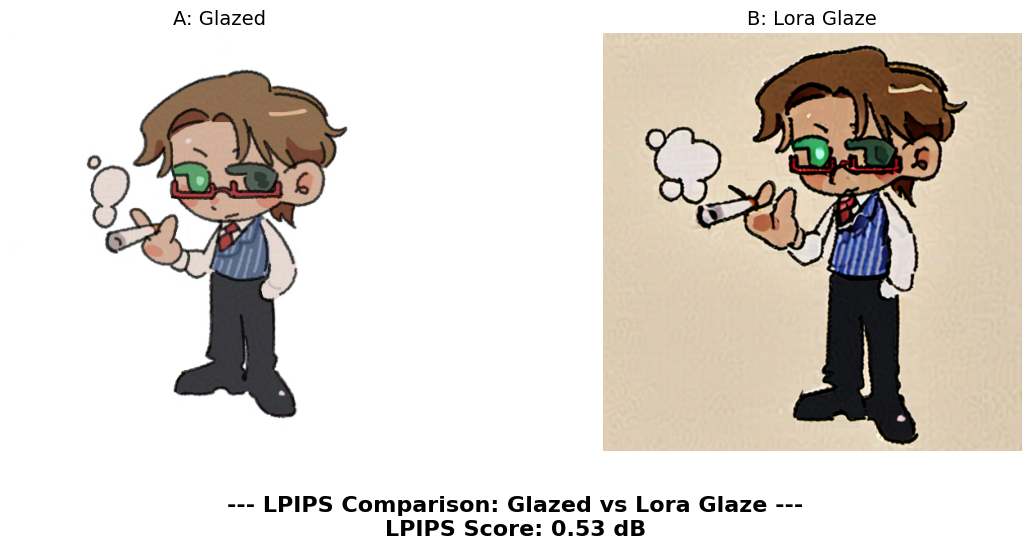

In [23]:
plot_lpips_comparison(glz_img, lora_glz_img, "Glazed", "Lora Glaze", glz_lpips)